In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Load TPMS and sleuth results

In [13]:
named_tpms = pd.read_hdf("../data/processed/tpm_matrix_named.hdf",key="named_tpms")

rpl22_oe = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22_oe.hdf", key="rpl22_oe")
rpl22l1_oe = pd.read_hdf("../data/intermediate/kallisto_sleuth/RPL22L1_oe.hdf", key="rpl22l1_oe")
sh704 = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh704.hdf", key="sh704")
sh705 = pd.read_hdf("../data/intermediate/kallisto_sleuth/sh705.hdf", key="sh705")

In [31]:
experiments = ['LNCaP_GFP_1',
               'LNCaP_GFP_2',
               'LNCaP_GFP_3',
               'LNCaP_RPL22_1',
               'LNCaP_RPL22_2',
               'LNCaP_RPL22_3',
               'CAL851_GFP_1',
               'CAL851_GFP_2',
               'CAL851_GFP_3',
               'CAL851_RPL22L1_1',
               'CAL851_RPL22L1_2',
               'CAL851_RPL22L1_3',
               'LNCaP_shLuc_1',
               'LNCaP_shLuc_2',
               'LNCaP_shLuc_3',
               'LNCaP_sh704_1',
               'LNCaP_sh704_2',
               'LNCaP_sh704_3',
               'LNCaP_sh705_1',
               'LNCaP_sh705_2',
               'LNCaP_sh705_3']

controls = ['LNCaP_GFP_1',
            'LNCaP_GFP_2',
            'LNCaP_GFP_3',
            'CAL851_GFP_1',
            'CAL851_GFP_2',
            'CAL851_GFP_3',
            'LNCaP_shLuc_1',
            'LNCaP_shLuc_2',
            'LNCaP_shLuc_3',
            'LNCaP_shLuc_1',
            'LNCaP_shLuc_2',
            'LNCaP_shLuc_3',
            ]

experiments = ['LNCaP_RPL22_1',
               'LNCaP_RPL22_2',
               'LNCaP_RPL22_3',
               'CAL851_RPL22L1_1',
               'CAL851_RPL22L1_2',
               'CAL851_RPL22L1_3',
               'LNCaP_sh704_1',
               'LNCaP_sh704_2',
               'LNCaP_sh704_3',
               'LNCaP_sh705_1',
               'LNCaP_sh705_2',
               'LNCaP_sh705_3']

# Differential expression

In [34]:
def plot_tpm_dist(transcript_id):
    
    select_abundance = named_tpms[transcript_id]

    expression_df = pd.DataFrame(index = controls+experiments)

    expression_df["Gene TPM"] = np.log2(select_abundance.loc[expression_df.index]+1)

    expression_df["treatment"] = ["Control"]*12 + ["Treatment"]*12

    expression_df["Experiment"] = (
        ["RPL22++"]*3 + ["RPL22L1++"]*3 + ["sh704"]*3 + ["sh705"]*3)*2

    plt.figure(figsize=(4, 2.5))

    sns.barplot(x="Experiment",
                y="Gene TPM",
                data=expression_df,
                hue="treatment",
                palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                ci=None)

    ax = sns.stripplot(x="Experiment",
                       y="Gene TPM",
                       data=expression_df,
                       hue="treatment",
                       dodge=True,
                       palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                       size=8,
                       jitter=False,
                       linewidth=2,
                       edgecolor="black",
                       alpha=0.75
                      )

    ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylim(0)
    
    plt.title(transcript_id.split("_")[0])
    
#     plt.savefig("../plots/"+gene_id+"_expression_distribution.pdf",bbox_inches="tight")


In [ ]:
named_tpms["RPL22L1_ENST00000295830.13"]

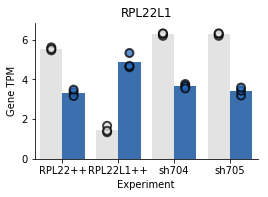

In [35]:
plot_tpm_dist("RPL22L1_ENST00000295830.13")

In [ ]:
plot_tpm_dist("RPL22L1_ENST00000295830.13")

# Differential splicing

In [38]:
exon_psis = pd.read_hdf(
    "../data/processed/suppa2_exon_psis.hdf", key="exon_psis").T

In [46]:
def plot_psi_dist(exon_id):
    
    select_abundance = exon_psis[exon_id]

    expression_df = pd.DataFrame(index = controls+experiments)

    expression_df["Gene TPM"] = np.log2(select_abundance.loc[expression_df.index]+1)

    expression_df["treatment"] = ["Control"]*12 + ["Treatment"]*12

    expression_df["Experiment"] = (
        ["RPL22++"]*3 + ["RPL22L1++"]*3 + ["sh704"]*3 + ["sh705"]*3)*2

    plt.figure(figsize=(4, 2.5))

    sns.barplot(x="Experiment",
                y="Gene TPM",
                data=expression_df,
                hue="treatment",
                palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                ci=None)

    ax = sns.stripplot(x="Experiment",
                       y="Gene TPM",
                       data=expression_df,
                       hue="treatment",
                       dodge=True,
                       palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                       size=8,
                       jitter=False,
                       linewidth=2,
                       edgecolor="black",
                       alpha=0.75
                      )

    ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylim(0)
    
    plt.title(exon_id.split("_")[0])
    
#     plt.savefig("../plots/"+gene_id+"_expression_distribution.pdf",bbox_inches="tight")


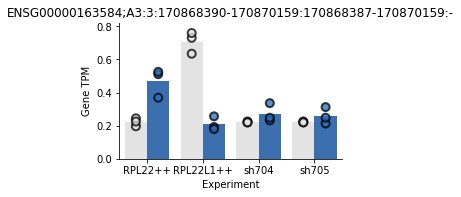

In [55]:
plot_psi_dist("ENSG00000163584;A3:3:170868390-170870159:170868387-170870159:-")

In [51]:
[x for x in exon_psis.columns if "ENSG00000163584" in x]

['ENSG00000163584;A3:3:170868201-170868298:170868134-170868298:-',
 'ENSG00000163584;A3:3:170868390-170870159:170868387-170870159:-',
 'ENSG00000163584;AF:3:170868390-170869965:170870033:170868390-170870159:170870195:-']